In [1]:
import rasterio, rasterio.mask
import fiona
import glob
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
import subprocess

In [2]:
sns.set_style('darkgrid')

## Process the rasters
The GNN data covers Oregon, Washington, and California. We are working in a subset or this area in western Oregon and western Washington only. We will clip the data to the relevant area of interest and stack the rasters into a multi-band image for analysis. We will end up with rasters for Oregon and Washington that cover the extent of the ecoregions we are interested in for each state, as well as the extent of the parcels we sampled (both random samples and FSC-certified properties) in each state.

In [48]:
# First, let's clip the gigantic GNN rasters to the ecoregions in Oregon and Washington
with fiona.open('./Spatial_Layers/ecoregions_by_state.shp', "r") as shapefile:
    oregon_features = [feature['geometry'] for feature in shapefile if feature['properties']['State'] == 'OR']
    washington_features = [feature['geometry'] for feature in shapefile if feature['properties']['State'] == 'WA']

In [47]:
rasters = glob.glob('./GNNrasters/*.tif')
rasters

['./GNNrasters\\age_float32.tif',
 './GNNrasters\\ba.tif',
 './GNNrasters\\biomass.tif',
 './GNNrasters\\siteindex_float32.tif',
 './GNNrasters\\volume.tif']

In [50]:
for raster in rasters:
    basename = os.path.basename(raster)
    print('Processing {}'.format(basename), end='... ')
    with rasterio.open(raster) as src:
        or_image, or_transform = rasterio.mask.mask(src, oregon_features, crop=True)
        or_meta = src.meta.copy()
        if or_meta['nodata'] == 65535: # the integer-formatted rasters were using this nodata value
            or_image[or_image == 65535] = -9999.0 # change it to -9999
        # some of the float rasters were using a negative number for nodata
        or_image[or_image < 0] = -9999.0 # let's make them all consistently -9999
        
        or_meta.update({"driver": "GTiff",
                        "height": or_image.shape[1],
                        "width": or_image.shape[2],
                        "transform": or_transform,
                        "nodata": -9999.0})
        
        wa_image, wa_transform = rasterio.mask.mask(src, washington_features, crop=True)
        wa_meta = src.meta.copy()
        if wa_meta['nodata'] == 65535:
            wa_image[wa_image == 65535] = -9999.0
        wa_image[wa_image < 0] = -9999.0
        
        wa_meta.update({"driver": "GTiff",
                        "height": wa_image.shape[1],
                        "width": wa_image.shape[2],
                        "transform": wa_transform,
                        "nodata": -9999.0})
        
        # write out the data into new rasters
        with rasterio.open('./GNNrasters/clipped/or_{}'.format(basename), "w", **or_meta) as dest:
            dest.write(or_image)
        with rasterio.open('./GNNrasters/clipped/wa_{}'.format(basename), "w", **wa_meta) as dest:
            dest.write(wa_image)
    print('Done.')

Processing age_float32.tif
Processing ba.tif
Processing biomass.tif
Processing siteindex_float32.tif
Processing volume.tif


In [57]:
# stack the rasters into multi-band images using the rasterio command line interface
_dir = './GNNrasters/clipped/'
cmd = 'rio stack {}or_age_float32.tif {}or_siteindex_float32.tif {}or_ba.tif {}or_volume.tif {}or_biomass.tif {}or_stacked.tif'.format(_dir)
subprocess.call(cmd)
cmd = 'rio stack {}wa_age_float32.tif {}wa_siteindex_float32.tif {}wa_ba.tif {}wa_volume.tif {}wa_biomass.tif {}wa_stacked.tif'.format(_dir)
subprocess.call(cmd)

## Extract the boundaries of all the parcels
We will use these to mask out areas outside the properties in the landscape rasters and save these to new arrays for both the randomly-selected and FSC-certified properties.

In [156]:
# read all the shapefile features using fiona
with fiona.open('./Spatial_Layers/parcel_boundaries.shp', "r") as shapefile:
    or_random_features = [feature['geometry'] for feature in shapefile if feature['properties']['state'] == 41 and feature['properties']['Type'] == 'random']
    or_fsc_features = [feature['geometry'] for feature in shapefile if feature['properties']['state'] == 41 and feature['properties']['Type'] == 'fsc']
    wa_random_features = [feature['geometry'] for feature in shapefile if feature['properties']['state'] == 53 and feature['properties']['Type'] == 'random']
    wa_fsc_features = [feature['geometry'] for feature in shapefile if feature['properties']['state'] == 53 and feature['properties']['Type'] == 'fsc']

In [157]:
# apply a mask to the Washington raster changing areas outside parcels to nodata
with rasterio.open("./GNNrasters/clipped/wa_stacked.tif") as src:
    wa_random_image, wa_random_transform = rasterio.mask.mask(src, wa_random_features, crop=True)
    wa_random_meta = src.meta.copy()
    wa_fsc_image, wa_fsc_transform = rasterio.mask.mask(src, wa_fsc_features, crop=True)
    wa_fsc_meta = src.meta.copy()

    wa_random_meta.update()
    wa_fsc_meta.update({"driver": "GTiff",
                        "height": wa_fsc_image.shape[1],
                        "width": wa_fsc_image.shape[2],
                        "transform": wa_fsc_transform})

# write the data out to a new raster                                                                        
with rasterio.open("./GNNrasters/clipped/wa_random_stacked.tif", "w", **wa_random_meta) as dest:
    dest.write(wa_random_image)
with rasterio.open("./GNNrasters/clipped/wa_fsc_stacked.tif", "w", **wa_fsc_meta) as dest:
    dest.write(wa_fsc_image)

In [158]:
# apply a mask to the Washington raster changing areas outside parcels to nodata
with rasterio.open("./GNNrasters/clipped/or_stacked.tif") as src:
    or_random_image, or_random_transform = rasterio.mask.mask(src, or_random_features, crop=True)
    or_random_meta = src.meta.copy()
    or_fsc_image, or_fsc_transform = rasterio.mask.mask(src, or_fsc_features, crop=True)
    or_fsc_meta = src.meta.copy()

    or_random_meta.update({"driver": "GTiff",
                           "height": or_random_image.shape[1],
                           "width": or_random_image.shape[2],
                           "transform": or_random_transform})
    or_fsc_meta.update({"driver": "GTiff",
                        "height": or_fsc_image.shape[1],
                        "width": or_fsc_image.shape[2],
                        "transform": or_fsc_transform})

# write the data out to a new raster                                                                        
with rasterio.open("./GNNrasters/clipped/or_random_stacked.tif", "w", **or_random_meta) as dest:
    dest.write(or_random_image)
with rasterio.open("./GNNrasters/clipped/or_fsc_stacked.tif", "w", **or_fsc_meta) as dest:
    dest.write(or_fsc_image)

## Remove nodata values from analysis/visualization workflow
For graphing the distributions of the data, we will flatten the rasters to a 1-dimensional array including only the valid data.

In [3]:
# gather all the data from the rasters
with rasterio.open("./GNNrasters/clipped/or_stacked.tif") as src:
    oregon = src.read(masked=True)
with rasterio.open("./GNNrasters/clipped/or_random_stacked.tif") as src:
    or_rand = src.read(masked=True)
with rasterio.open("./GNNrasters/clipped/or_fsc_stacked.tif") as src:
    or_fsc = src.read(masked=True)    

with rasterio.open("./GNNrasters/clipped/wa_stacked.tif") as src:
    washington = src.read(masked=True)
with rasterio.open("./GNNrasters/clipped/wa_random_stacked.tif") as src:
    wa_rand = src.read(masked=True)
with rasterio.open("./GNNrasters/clipped/wa_fsc_stacked.tif") as src:
    wa_fsc = src.read(masked=True)

In [4]:
# the .compressed() method on a masked array returns a flattened array with all nodata values removed
# we'll call this method and assign the data to easier-to-use objects

or_age, or_site = oregon[0,...].compressed(), oregon[1,...].compressed()
or_ba, or_vol, or_bio  = oregon[2,...].compressed(), oregon[3,...].compressed(), oregon[4,...].compressed()

or_rand_age, or_rand_site, = or_rand[0,...].compressed(), or_rand[1,...].compressed() 
or_rand_ba, or_rand_vol, or_rand_bio  = or_rand[2,...].compressed(), or_rand[3,...].compressed(), or_rand[4,...].compressed()

or_fsc_age, or_fsc_site = or_fsc[0,...].compressed(), or_fsc[1,...].compressed()
or_fsc_ba, or_fsc_vol, or_fsc_bio = or_fsc[2,...].compressed(), or_fsc[3,...].compressed(), or_fsc[4,...].compressed()

wa_age, wa_site = washington[0,...].compressed(), washington[1,...].compressed()
wa_ba, wa_vol, wa_bio = washington[2,...].compressed(), washington[3,...].compressed(), washington[4,...].compressed()

wa_rand_age, wa_rand_site = wa_rand[0,...].compressed(), wa_rand[1,...].compressed()
wa_rand_ba, wa_rand_vol, wa_rand_bio = wa_rand[2,...].compressed(), wa_rand[3,...].compressed(), wa_rand[4,...].compressed()

wa_fsc_age, wa_fsc_site = wa_fsc[0,...].compressed(), wa_fsc[1,...].compressed()
wa_fsc_ba, wa_fsc_vol, wa_fsc_bio = wa_fsc[2,...].compressed(), wa_fsc[3,...].compressed(), wa_fsc[4,...].compressed()

In [5]:
# we can choose the bounds for our data visualization and/or bins for generating histograms
min(or_bio.min(), wa_bio.min())/1000, max(or_bio.max(), wa_bio.max())/1000

(0.0, 2101.07525)

## Visualize the distributions of the sampled properties and the landscape

In [6]:
# set up some bins for doing the histogram
age_bins = np.arange(0, 850, 10)
site_bins = np.arange(0, 135*0.3048, 3*0.3048)
ba_bins = np.arange(0, 300, 5)
vol_bins = np.arange(0,8750, 60)
bio_bins = np.arange(0,2150, 30)
bins = [age_bins, site_bins, ba_bins, vol_bins, bio_bins]

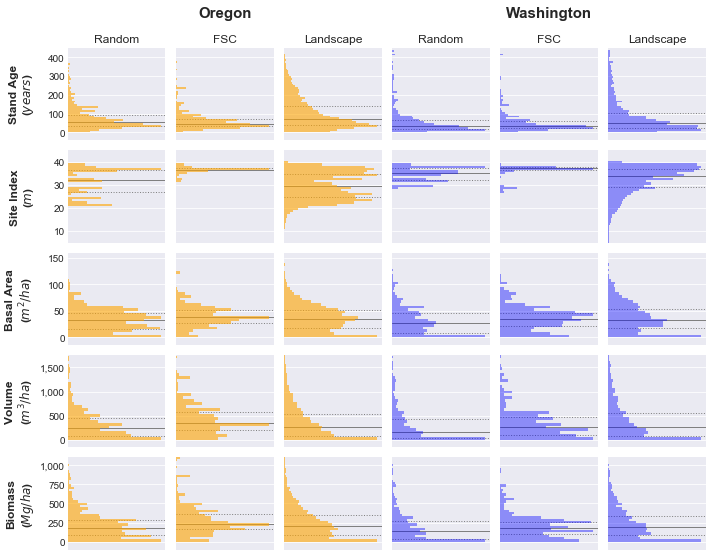

In [7]:
dims = oregon.shape[0]
fig, axs = plt.subplots(dims,6, figsize =(10,8), sharex=False, sharey='row')

or_rand_metrics = [or_rand_age, or_rand_site*0.3048, or_rand_ba, or_rand_vol, or_rand_bio/1000]
wa_rand_metrics = [wa_rand_age, wa_rand_site*0.3048, wa_rand_ba, wa_rand_vol, wa_rand_bio/1000]
or_fsc_metrics = [or_fsc_age, or_fsc_site*0.3048, or_fsc_ba, or_fsc_vol, or_fsc_bio/1000]
wa_fsc_metrics = [wa_fsc_age, wa_fsc_site*0.3048, wa_fsc_ba, wa_fsc_vol, wa_fsc_bio/1000]
or_metrics = [or_age, or_site*0.3048, or_ba, or_vol, or_bio/1000]
wa_metrics = [wa_age, wa_site*0.3048, wa_ba, wa_vol, wa_bio/1000]
y_lims = [(None,450), (5,45), (None,160), (-150,1750), (None,1100)]
y_labels = ['Stand Age\n($years$)', 'Site Index\n($m$)', 'Basal Area\n($m^2/ha$)', 'Volume\n($m^3/ha$)', 'Biomass\n($Mg/ha$)']
titles = ['Random', 'FSC', 'Landscape','Random', 'FSC', 'Landscape']
ext = [] # will hold bounding boxes of subplots

# draw the graphs
for i in range(dims):
    # plot the oregon distributions
    # histogram for oregon random properties
    sns.distplot(or_rand_metrics[i], bins=bins[i], vertical=True, kde=False, color='orange',
                 ax=axs[i,0], hist_kws={'normed':None, 'density':True, 'zorder': 2, 'alpha':0.6})
    # 25th, 50th, and 75th percentiles as horizontal lines
    percentiles = np.percentile(or_rand_metrics[i], [25,50,75])
    axs[i,0].axhline(y=percentiles[0], color='gray', linewidth=1, linestyle=':', zorder=1)
    axs[i,0].axhline(y=percentiles[1], color='gray', linewidth=1, zorder=1)
    axs[i,0].axhline(y=percentiles[2], color='gray', linewidth=1, linestyle=':', zorder=1)
    
    # histogram for oregon fsc properties
    sns.distplot(or_fsc_metrics[i], bins=bins[i], vertical=True, kde=False, color='orange',
                 ax=axs[i,1], hist_kws={'normed':None, 'density':True, 'zorder': 2, 'alpha':0.6})
    # 25th, 50th, and 75th percentiles as horizontal lines
    percentiles = np.percentile(or_fsc_metrics[i], [25,50,75])
    axs[i,1].axhline(y=percentiles[0], color='gray', linewidth=1, linestyle=':', zorder=1)
    axs[i,1].axhline(y=percentiles[1], color='gray', linewidth=1, zorder=1)
    axs[i,1].axhline(y=percentiles[2], color='gray', linewidth=1, linestyle=':', zorder=1)
    
    # histogram for western oregon landscape
    sns.distplot(or_metrics[i], bins=bins[i], vertical=True, kde=False, color='orange',
                 ax=axs[i,2], hist_kws={'normed':None, 'density':True, 'zorder': 2, 'alpha':0.6})
    # 25th, 50th, and 75th percentiles as horizontal lines
    percentiles = np.percentile(or_metrics[i], [25,50,75])
    axs[i,2].axhline(y=percentiles[0], color='gray', linewidth=1, linestyle=':', zorder=1)
    axs[i,2].axhline(y=percentiles[1], color='gray', linewidth=1, zorder=1)
    axs[i,2].axhline(y=percentiles[2], color='gray', linewidth=1, linestyle=':', zorder=1)
    
    # plot the washington distributions
    # histogram for washington random properties
    sns.distplot(wa_rand_metrics[i], bins=bins[i], vertical=True, kde=False, color='blue',
                 ax=axs[i,3], hist_kws={'normed':None, 'density':True, 'zorder': 2, 'alpha':0.4})
    # 25th, 50th, and 75th percentiles as horizontal lines
    percentiles = np.percentile(wa_rand_metrics[i], [25,50,75])
    axs[i,3].axhline(y=percentiles[0], color='gray', linewidth=1, linestyle=':', zorder=1)
    axs[i,3].axhline(y=percentiles[1], color='gray', linewidth=1, zorder=1)
    axs[i,3].axhline(y=percentiles[2], color='gray', linewidth=1, linestyle=':', zorder=1)
    
    # histogram for washington fsc properties
    sns.distplot(wa_fsc_metrics[i], bins=bins[i], vertical=True,  kde=False, color='blue',
                 ax=axs[i,4], hist_kws={'normed':None, 'density':True, 'zorder': 2, 'alpha':0.4})
    # 25th, 50th, and 75th percentiles as horizontal lines
    percentiles = np.percentile(wa_fsc_metrics[i], [25,50,75])
    axs[i,4].axhline(y=percentiles[0], color='gray', linewidth=1, linestyle=':', zorder=1)
    axs[i,4].axhline(y=percentiles[1], color='gray', linewidth=1, zorder=1)
    axs[i,4].axhline(y=percentiles[2], color='gray', linewidth=1, linestyle=':', zorder=1)
    
    # histogram for western washington landscape
    sns.distplot(wa_metrics[i], bins=bins[i], vertical=True, kde=False, color='blue',
                 ax=axs[i,5], hist_kws={'normed':None, 'density':True, 'zorder': 2, 'alpha':0.4})
    # 25th, 50th, and 75th percentiles as horizontal lines
    percentiles = np.percentile(wa_metrics[i], [25,50,75])
    axs[i,5].axhline(y=percentiles[0], color='gray', linewidth=1, linestyle=':', zorder=1)
    axs[i,5].axhline(y=percentiles[1], color='gray', linewidth=1, zorder=1)
    axs[i,5].axhline(y=percentiles[2], color='gray', linewidth=1, linestyle=':', zorder=1)
    
# formatting the graph
    axs[i,0].set_ylim(y_lims[i])
    axs[i,0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    axs[i,0].set_ylabel(y_labels[i], weight='bold', fontsize=12)

for row in range(5):
    # for all columns except the first one
    for col in range(1,6):
        # remove y-ticks
        axs[row][col].tick_params(axis='y', left=False)

# add extra gridlines/y-ticks to some graphs
axs[0,0].set_yticks([0,100,200,300,400])
axs[4,0].set_yticks([0,250,500,750,1000])

# remove x-ticks for all graphs
plt.setp(axs, xticks=[])
# add titles to the top row of plots
for j in range(axs.shape[1]):
    axs[0,j].set_title(titles[j])

plt.tight_layout()

# add titles to the top row of plots and get their bounding boxes
ext = []
for j in range(axs.shape[1]):
    ext.append([axs[0,j].get_window_extent().x0, axs[0,j].get_window_extent().width])
    
# from the axes bounding boxes calculate the optimal position of a column spanning title
inv = fig.transFigure.inverted()
width_left = ext[0][0]+(ext[2][0] + ext[2][1] - ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )
width_right = ext[3][0]+(ext[5][0]+ext[5][1]-ext[3][0])/2.
right_center = inv.transform( (width_right, 1) )

# adjust the subplots, i.e. leave more space at the top to accomodate the State names
fig.subplots_adjust(top=0.89)
plt.figtext(left_center[0],0.95,"Oregon", va="center", ha="center", size=15, weight='bold')
plt.figtext(right_center[0],0.95,"Washington", va="center", ha="center", size=15, weight='bold')
fig.align_labels()
plt.savefig('../images/parcels_v_landscape.png');